# AirBnB : Part 1b : data preparation for reviews text.

In this part, we briefly analyze the content of the text reviews.

Then after having vectorized those reviews, we will use dimensionality reduction to make them usable as predictors.

At the end of the process, using the Principal Components Eigenvectors,  we build new features and add them to the listing dataset.

In [78]:
%matplotlib inline

import numpy as np
from ggplot import *
import pandas as pd
from langdetect import detect
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,HashingVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import MinMaxScaler,MaxAbsScaler
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.decomposition import TruncatedSVD


from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix,classification_report

from xgboost import XGBRegressor

import nltk
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from utils import detect_lang,rstr,df_to_markdown

## Label the reviews per language

Before proceeding to text vectorization, we label each review with its corresponding language.

To implement this, i use the the [langdetect](https://pypi.python.org/pypi/langdetect?) package

In [2]:
def add_language_to_reviews(df):
    df_reviews = pd.read_csv('../../data/insideAirBnB/reviews.csv')
    df_reviews["comments2"] = df_reviews.comments.apply(lambda x:str(x).decode('utf-8'))
    df_reviews['language']= df_reviews.comments2.apply(detect_lang)
    df_reviews.to_csv("../../data/reviews_with_lang.csv")

In [3]:
df_reviews = pd.read_csv('../../data/reviews_with_lang.csv')

# drop missing reviews
df_reviews = df_reviews[~df_reviews.comments.isnull()]

# retrieve clean listing data from Data Preparation
df_listing = pd.read_csv('../../data/listing_cleansed.csv')


In [4]:
df_listing.columns

Index([u'listing_id', u'host_id', u'host_name', u'host_since',
       u'host_response_time', u'host_response_rate', u'host_is_superhost',
       u'host_listings_count', u'host_has_profile_pic',
       u'host_identity_verified',
       ...
       u'text_description', u'text_experiences_offered',
       u'text_neighborhood_overview', u'text_notes', u'text_transit',
       u'text_access', u'text_interaction', u'text_house_rules',
       u'text_host_about', u'text_language'],
      dtype='object', length=220)

Once each reviews has been labelled, we can proceed to a short analysis regarding the relationships between the languages reviews and the appartment rating.

In [5]:
df_reviews  = pd.merge(df_reviews,df_listing[['listing_id','review_scores_rating','review_scores_cleanliness','availability_30','availability_90','reviews_per_month','price','host_listings_count']],on='listing_id' )

### Cancelled reservations

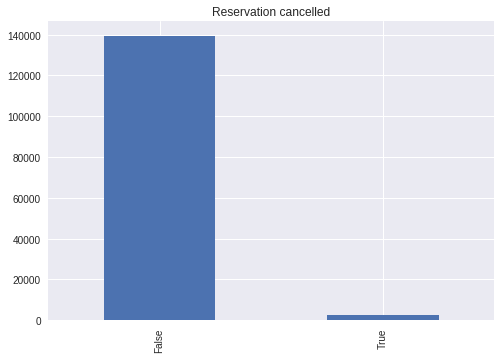

In [6]:
df_reviews.comments.str.contains('The host canceled this reservation').value_counts(dropna=False).plot.bar(title='Reservation cancelled')

### Drop cancelled reservations

In [7]:
df_reviews = df_reviews[~df_reviews.comments.str.contains('The host canceled this reservation')]

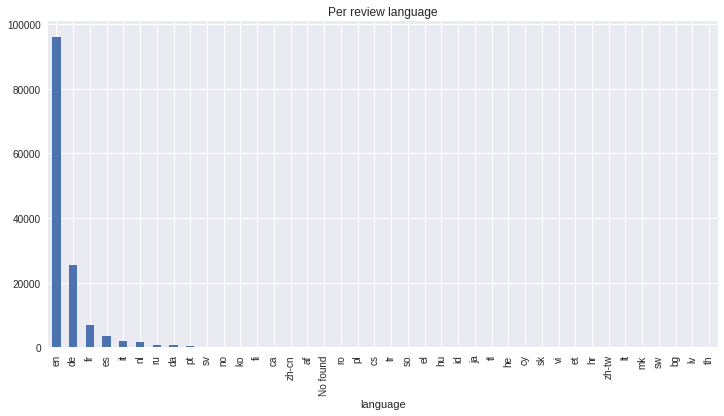

In [8]:
groupy_per_lang = df_reviews.groupby('language').comments.count().sort_values(ascending = False)

groupy_per_lang.plot.bar(title="Per review language",figsize=(12, 6))

In [9]:
df_lang = pd.DataFrame(groupy_per_lang)
df_lang['% total reviews']=np.round(df_lang.comments/df_lang.comments.sum()*100.0,2)
df_lang.head()

,comments,% total reviews
language,,
en,96099,68.86
de,25476,18.25
fr,7021,5.03
es,3664,2.63
it,1907,1.37


From this chart, we will only use reviews written in english (69% of the total reviews)

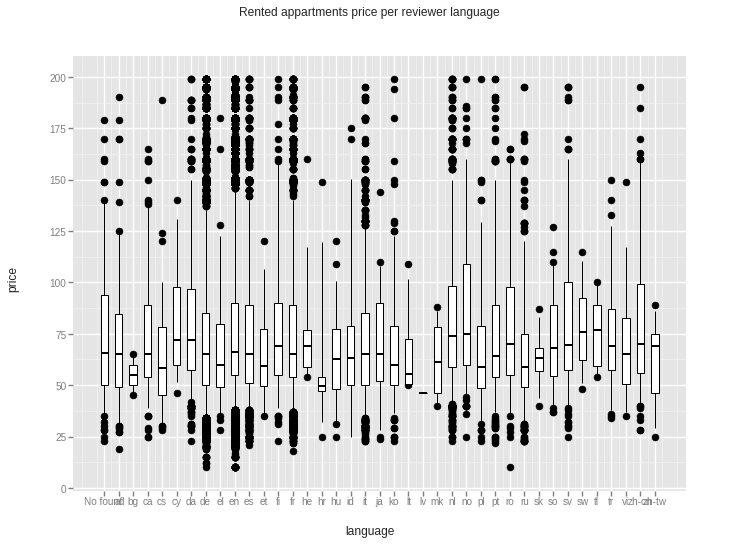

<ggplot: (8735242698621)>

In [10]:
ggplot(df_reviews[df_reviews.price<200],aes(x='language', y='price'))+geom_boxplot() +ggtitle('Rented appartments price per reviewer language')

Out of scope here, but still interesting, the high median price for scandinavian hosts, and low ones for countries from Balkans.

In [11]:
def concat_comments(x):
    x = x.str.replace(r'[^a-zA-Z\d\s:]','')
    return "%s" % '- '.join(x)

df_reviews_eng = df_reviews[df_reviews.language=='en']

df_reviews_eng = df_reviews_eng[~df_reviews_eng.review_scores_rating.isnull()]
df_reviews_eng = df_reviews_eng[~df_reviews_eng.comments.str.contains('The host canceled this reservation')]
df_reviews_eng = df_reviews_eng[~df_reviews_eng.comments.str.contains('reservation was canceled')]



In [12]:
df_reviews_grouped  = df_reviews_eng.groupby('listing_id').agg({'comments': concat_comments})

In [13]:
df_reviews_grouped = df_reviews_grouped.reset_index()
df_reviews_grouped.head()

,listing_id,comments
0,1971,great location and out look over the spree flu...
1,2015,Jan was very friendly and welcoming host The a...
2,3176,excellent stay i would highly recommend it a n...
3,9991,The host was very welcoming and hospitable He ...
4,11203,He was a kind and polite gentleman\r\n\r\nThe ...


In [14]:
df_listing_with_reviews = pd.merge(df_listing,df_reviews_grouped,on='listing_id',how='left')

In [15]:
print df_listing.shape
print df_listing_with_reviews.shape


(9208, 220)
(9208, 221)


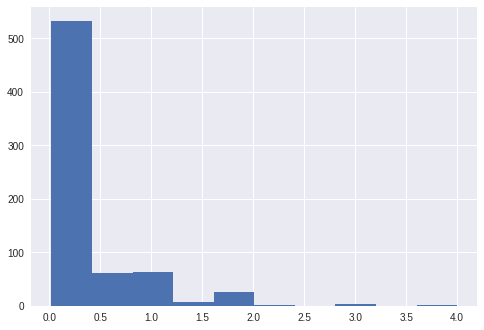

In [16]:
df_listing_with_reviews[df_listing_with_reviews.comments.isnull()].reviews_per_month.hist()

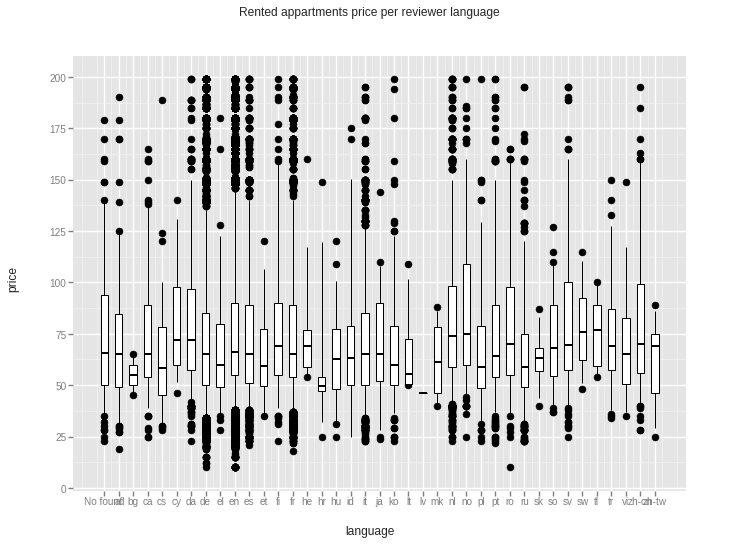

<ggplot: (8735242698517)>

In [17]:
ggplot(df_reviews[df_reviews.price<200],aes(x='language', y='price'))+geom_boxplot() +ggtitle('Rented appartments price per reviewer language')

In [18]:
df_listing_with_reviews.comments = df_listing_with_reviews.comments.str.lower()
df_listing_with_reviews.comments = df_listing_with_reviews.comments.fillna("no comment")

df_listing_with_reviews.comments = df_listing_with_reviews.comments.astype(str)

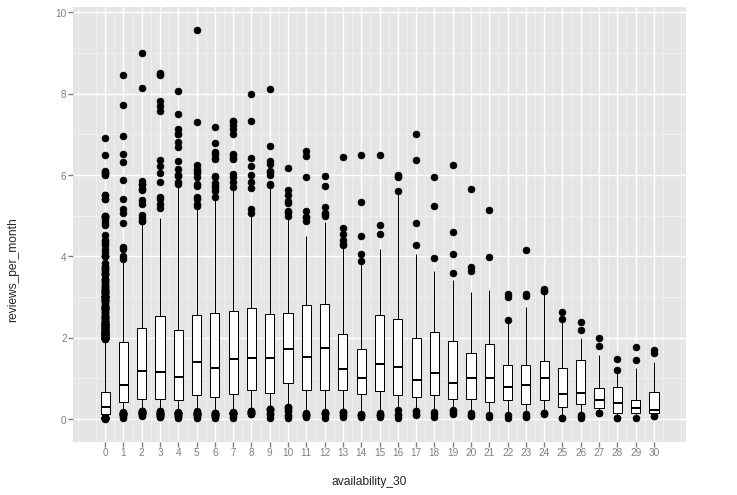

<ggplot: (8735235763653)>

In [19]:
ggplot(df_listing_with_reviews,aes(x='availability_30',y='reviews_per_month'))+geom_boxplot()

Critical informations here : The appartments with Zero availability are mostly appartments that are not rented (very low number of reviews per months) rather than fully booked. We can exclude them.

In [20]:
df_listing_with_reviews[['review_scores_rating','availability_90','availability_30']].describe()

,review_scores_rating,availability_90,availability_30
count,7600.000000,9208.000000,9208.000000
mean,93.277763,17.376520,4.290400
std,7.854820,25.105169,7.091632
min,20.000000,0.000000,0.000000
25%,90.000000,0.000000,0.000000
50%,95.000000,3.000000,0.000000
75%,100.000000,27.000000,6.000000
max,100.000000,90.000000,30.000000


### Remove stop words, host names and Stem text reviews.

#### Host names

In [21]:
all_host_names = df_listing.host_name.str.lower()
all_host_names = all_host_names.unique().tolist()

In [22]:
len(all_host_names)

3213

#### Stop words and stem

In [23]:
porter = nltk.stem.porter.PorterStemmer()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

stop = nltk.corpus.stopwords.words('english')
stop =list(set(stop)-set(['no', 'not', 'never','don\'t','couldn\'t']))+all_host_names+['-']

### Implement a simple binary categories : good / bad appartment according to the review score rating

In [24]:
df_listing_with_reviews['is_multiple_host']=np.where(df_listing_with_reviews.host_listings_count>1,'single_host','multiple_host')
X = df_listing_with_reviews.comments.values
y = df_listing_with_reviews.is_multiple_host.values

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

# TEST

In [25]:
df_listing_with_reviews[df_listing_with_reviews.comments.str.contains('posting')].comments.head(1).values

array([ 'the room was exactly as promised clean and cosy really nice that they provided towels and sheets for us  they were also really flexible with our late check in would definitely come back to them if i find myself in berlin again : - if youre looking for a neighborhood full of live and young people this is the place alan was in a hurry but it tooks time for us thanks for the story of the noodle fish i will always remember it busy and noisy neighborhood located a few block from the heart of friedrichshain i always recomend to do bikes but not from second bikes remember this go somewhere else and last but not least the best shower in whole europe trust me- alan was punctual and friendly upon our arrival and kasia was always quick to respond to emails and was helpful the space is great for a short stay in berlin the apartment is located away from the main friedrichshain area but you are close to the tram and lots of amenities  and one of the best pizzas pomodorino also close by is t

In [26]:
vectorizer = TfidfVectorizer(ngram_range=(2,3),tokenizer=tokenizer_porter,stop_words=stop,max_features=5000)
df_listing_with_reviews.comments=df_listing_with_reviews.comments.apply(lambda x: x.replace('no comment',' '))

X_test_vectorized =vectorizer.fit_transform(df_listing_with_reviews.comments)

In [47]:
df_listing_with_reviews.comments.shape

(9208,)

In [48]:
vectorizer.idf_.shape

(5000,)

In [49]:
X_test_vectorized.shape

(9208, 5000)

In [50]:
X_test_vectorized.todense().shape

(9208, 5000)

In [51]:
X_test_vectorized.shape
X_test_vectorized_scaled = MinMaxScaler().fit_transform(X_test_vectorized.todense())

In [52]:
df_tfidf=pd.DataFrame(X_test_vectorized_scaled,columns=vectorizer.get_feature_names())

In [53]:
df_listing_with_reviews.iloc[9184].comments

'i did not meet semra but she is very nice and she asked someone else to open the door for me a very pleasant stay in the apartment i had everything i need in the roon unfortunatelly i could not stay longer because of the business trip- semra was an extremely friendly host and the flat was great- the apartment: so cozy comfortable clean tidy very well equipped and good location with 8 minutes walking to the subway station u8 \nthe host: very hospitable respectable cooperative nice person and really you feel yourself at home  thank you semra for your great hosting definitely i will repeat the experience to visit berlin and stay in your cozy flat- my wife stayed with semra for a few nights and very much enjoyed the experience located a short walk from the ubahn perfect for getting into the city the apartment was clean tidy and well furnished semra was a lovely host helpful and socialable many thanks- the host was very prompt in responding helpful and made everything easy- this was truely

In [54]:
df_tfidf.head()

,1 minut,10 day,10 minut,10 minut walk,10 walk,100 recommend,1015 minut,10min walk,15 minut,15 minut walk,...,would suggest,would total,would total recommend,would veri,wouldnt hesit,year old,yet veri,youd need,youll find,youll need
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.369119,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [55]:
svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)

In [56]:
df_tfidf_PCA = svd.fit_transform(X_test_vectorized_scaled)

In [57]:
svd.explained_variance_.sum()

0.29299044720219414

In [58]:
df_tfidf_PCA.min()

-0.70590254292644572

In [73]:
df_pca_components =pd.DataFrame(svd.components_,columns=vectorizer.get_feature_names(),index = ['PC1','PC2']).transpose()

In [74]:
df_pca_components['PC1_abs']=np.abs(df_pca_components.PC1)
df_pca_components['PC2_abs']=np.abs(df_pca_components.PC2)
df_pca_components = df_pca_components.sort_values(by='PC1_abs',ascending=False)

In [82]:
df_pca_components = df_pca_components.reset_index()
df_pca_components.head(20)

,level_0,index,PC1,PC2,PC1_abs,PC2_abs
0,0,apart wa,0.280195,-0.335142,0.280195,0.335142
1,1,wa veri,0.204795,-0.202012,0.204795,0.202012
2,2,everyth need,0.158712,0.019525,0.158712,0.019525
3,3,would definit,0.148482,0.222251,0.148482,0.222251
4,4,recommend thi,0.145673,0.359492,0.145673,0.359492
5,5,public transport,0.127669,-0.074664,0.127669,0.074664
6,6,veri clean,0.117286,-0.118777,0.117286,0.118777
7,7,veri help,0.114542,-0.080589,0.114542,0.080589
8,8,great locat,0.101401,0.000003,0.101401,0.000003
9,9,wa great,0.100505,-0.030206,0.100505,0.030206


In [76]:
print df_to_markdown(df_pca_components[['index','PC1','PC2']].head(20))

index | PC1 | PC2
---- | ---- | ----
apart wa | 0.28 | -0.34
wa veri | 0.2 | -0.2
everyth need | 0.16 | 0.02
would definit | 0.15 | 0.22
recommend thi | 0.15 | 0.36
public transport | 0.13 | -0.075
veri clean | 0.12 | -0.12
veri help | 0.11 | -0.081
great locat | 0.1 | 2.7e-06
wa great | 0.1 | -0.03
stay apart | 0.096 | -0.019
veri nice | 0.094 | -0.05
wa clean | 0.087 | -0.15
flat wa | 0.086 | -0.025
walk distanc | 0.085 | 0.011
thi apart | 0.085 | 0.083
highli recommend | 0.084 | 0.13
minut walk | 0.082 | -0.036
apart veri | 0.081 | -0.018
wa veri help | 0.081 | -0.09



In [79]:
df_listing_with_reviews['PC1']= df_tfidf_PCA[:,0]
df_listing_with_reviews['PC2']= df_tfidf_PCA[:,1]                    

In [80]:
sns.set_style("darkgrid", { 'font.family': ['cmr10']})

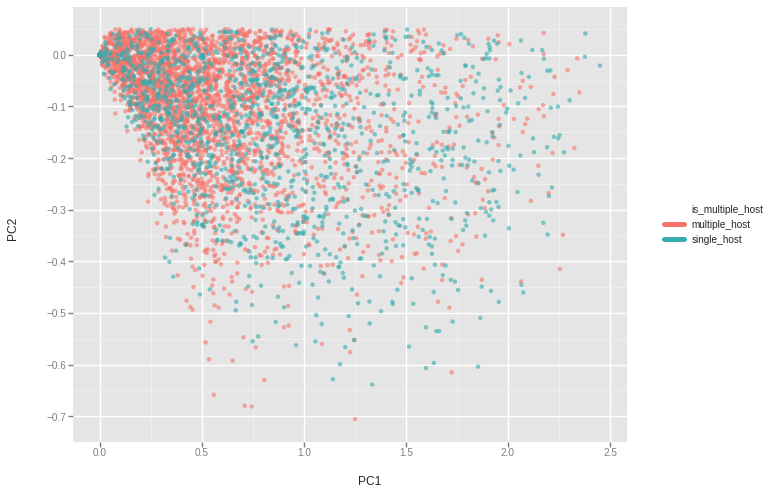

<ggplot: (8735233987033)>

In [81]:
ggplot(df_listing_with_reviews[df_listing_with_reviews.PC2<.05],aes('PC1','PC2',color='is_multiple_host'))+geom_point(alpha=.6)

### Vectorize text using Tfidf

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(2,3),tokenizer=tokenizer_porter,stop_words=stop,max_features=20000)
X_train_vectorized = vectorizer.fit_transform(X_train).todense()

### Scale data for PCA

In [ ]:
scaler = MinMaxScaler()
X_train_vectorized = scaler.fit_transform(X_train_vectorized)

In [ ]:
X_test_vectorized = vectorizer.transform(X_test).todense()
X_test_vectorized = scaler.transform(X_test_vectorized)

### Quick classification overview

In order the check wether using the reviews as predictor, we can run a simple classification tasks on whether the review score is higher than the median value (94%, which balances the dataset):

In [ ]:
clf = MultinomialNB()
clf.fit(X_train_vectorized,y_train)
predicted = clf.predict(X_test_vectorized)

In [ ]:
print confusion_matrix(y_test,predicted)
print classification_report(predicted,y_test)

Even if not very accurate, using those features could be good additional predictor for our regressor.

In [ ]:
idf = vectorizer.idf_
df_idf = pd.DataFrame.from_dict(dict(zip(vectorizer.get_feature_names(), idf)),orient='index')
df_idf.columns=['TFIDF']
df_idf = df_idf.sort_values(by='TFIDF',ascending=False)
df_idf.head()

Interesting enough, we can check which stemmed word are weighting the most in this binary classification :

In [ ]:
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print "\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2)
        
show_most_informative_features(vectorizer,clf,n=40)

Well, toilet papers, bad internet, broken shower head seem to be a no-go.

### Dimensionality reduction


Now we have scaled vectorized vector using Tfidf, we can reduce the number of columns using a PCA

In [ ]:
n_components=300
svd = TruncatedSVD(n_components=n_components)
X_train_svd = svd.fit_transform(X_train_vectorized)
X_test_svd = svd.transform(X_test_vectorized)

In [ ]:
print "Explained variance with {0} components : {1}".format(n_components,svd.explained_variance_ratio_.sum()*100)

## Add PCA of reviews to dataset :

Finally, we can vectorize the full set with Tfidf, scale it, and use PCA to summarize with only 300 vectors :

In [ ]:
X_all_reviews = vectorizer.fit_transform(X).todense()
X_all_reviews_TFIDF_scaled =scaler.fit_transform(X_all_reviews)

In [ ]:
print X.shape
print X_all_reviews.shape
print X_all_reviews_TFIDF_scaled.shape

In [ ]:
X_all_reviews_PCA = svd.fit_transform(X_all_reviews_TFIDF_scaled)
print svd.explained_variance_ratio_.sum()*100

Via a PCA, we dropped the reviews matrix from 20000 columns to 300.
We can now append it to the listing dataset :

In [ ]:
X_all_reviews_PCA.shape

In [ ]:
df_reviews_PCA = pd.DataFrame(X_all_reviews_PCA)
df_reviews_PCA.columns = ['reviews_PC_'+str(i) for i in range(1,n_components+1) ]

In [ ]:
df_reviews_PCA.shape

In [ ]:
df_reviews_PCA.columns

In [ ]:
df_listing_with_reviews.columns

In [ ]:
df_listing_with_reviews = pd.concat([df_listing_with_reviews[['listing_id']],df_reviews_PCA],axis=1)

In [ ]:
df_listing_with_reviews.to_csv('../../data/df_listings_with_reviews_PCA.csv',index=False)

In [ ]:
df_listing_with_reviews.shape